In [37]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [38]:
data_dir = Path.cwd().parent / "data"

df_train_features = pd.read_csv(data_dir / "dengue_features_train.csv")
df_train_labels = pd.read_csv(data_dir / "dengue_labels_train.csv")
df_test_features = pd.read_csv(data_dir / "dengue_features_test.csv")

In [39]:
df_train = df_train_features.copy()
df_train["total_cases"] = df_train_labels["total_cases"]

In [41]:
df_all_features = pd.concat([df_train_features, df_test_features])

In [43]:
df_all_features.shape

(1872, 24)

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

Mostly numeric features. City, year/week of year will be treated as categorical, week_start_date will be treated as a datetime. The target (`total_cases`) is a numeric variable.

In [54]:
# .count() returns non-null rows
null_counts = pd.DataFrame(
    [(len(df_train_features) - df_train_features.count()) / len(df_train_features),
     (len(df_test_features) - df_test_features.count()) / len(df_test_features)]
).transpose().reset_index()
null_counts.rename({"index": "Column", 0: "Train", 1: "Test"}, axis=1, inplace=True)
# Groups Train and Test columns together
null_counts = pd.melt(null_counts, id_vars=["Column"], value_vars=["Train", "Test"]).rename({"variable": "Dataset"}, axis=1)

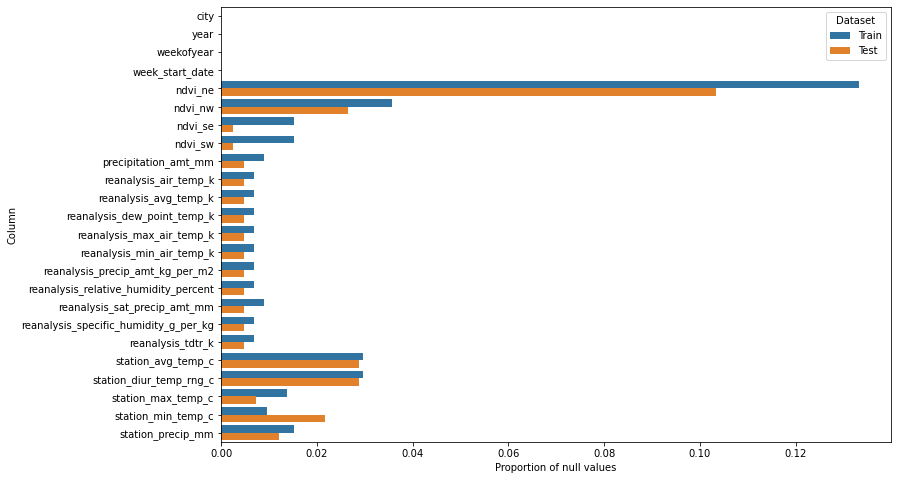

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))
_ = sns.barplot(x="value", y="Column", hue="Dataset", data=null_counts, orient="h", ax=ax)
_ = ax.set_xlabel("Proportion of null values")

Similar proportion of missing values across the Train/Test dataset, except for `ndvi_se` and `ndvi_sw`.

`ndvi_ne` has a significant amount of missing values.

Imputation may be necessary.

## Compare feature between cities (both train and test dataset)

In [59]:
numeric_cols = df_all_features.select_dtypes(include=[np.number]).drop(["year", "weekofyear"], axis=1).columns

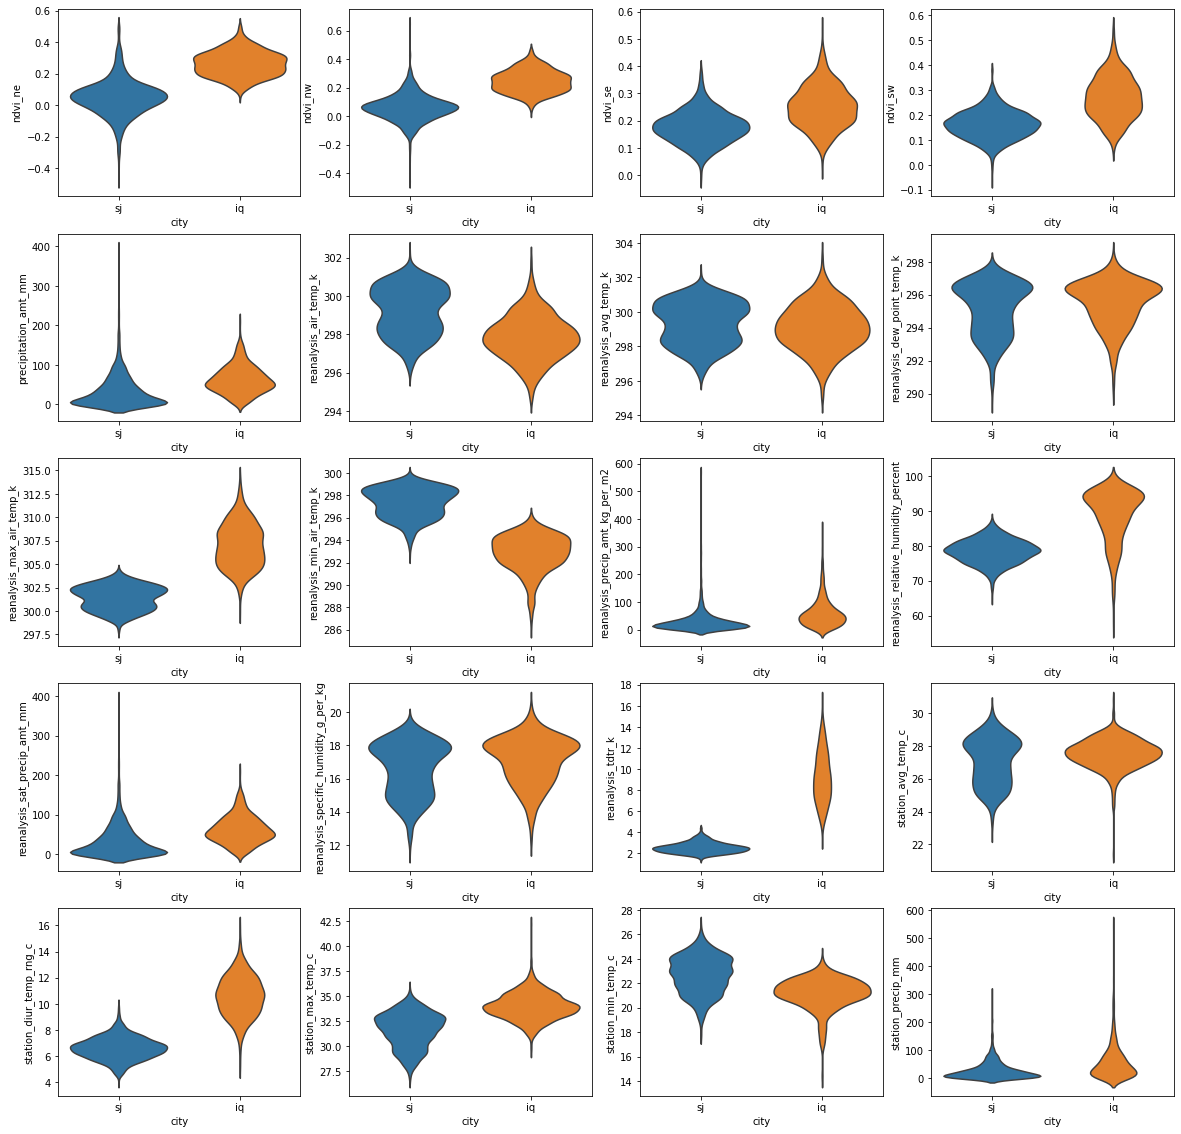

In [70]:
num_cols = int(np.sqrt(len(numeric_cols)))
num_rows = int(np.ceil(len(numeric_cols) / num_cols))

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
for i, col_name in enumerate(numeric_cols):
    col = int(i % num_cols)
    row = int(i / num_cols)
    sns.violinplot(x="city", y=col_name, data=df_all_features, inner=None, ax=ax[row][col])

`reanalysis_max_air_temp_k`, `reanalysis_min_air_temp_k`, `reanalysis_relative_humidity_percent`, `reanalysis_tdtr_k`, `station_diur_temp_rng_c` do not appear to have the same distribution between the two cities.

Some temperature features are reported in kelvin which others in celsius, we should convert all to be consistent. Perhaps to celsius so that the different in mean 

<AxesSubplot:xlabel='year', ylabel='Density'>

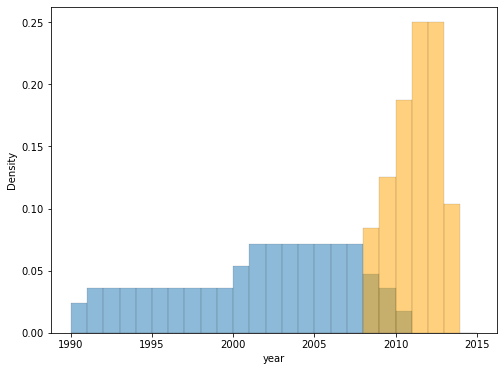

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.histplot(df_train_features["year"], stat="density", bins=np.arange(1990, 2016), alpha=0.5, linewidth=0.1, ax=ax)
sns.histplot(df_test_features["year"], stat="density", bins=np.arange(1990, 2016), color="orange", alpha=0.5, linewidth=0.1, ax=ax)

Measures are taken from different time periods between train and test datasets. There is some overlap between the train and test at 2008-2010.

## Compare train and test features between cities

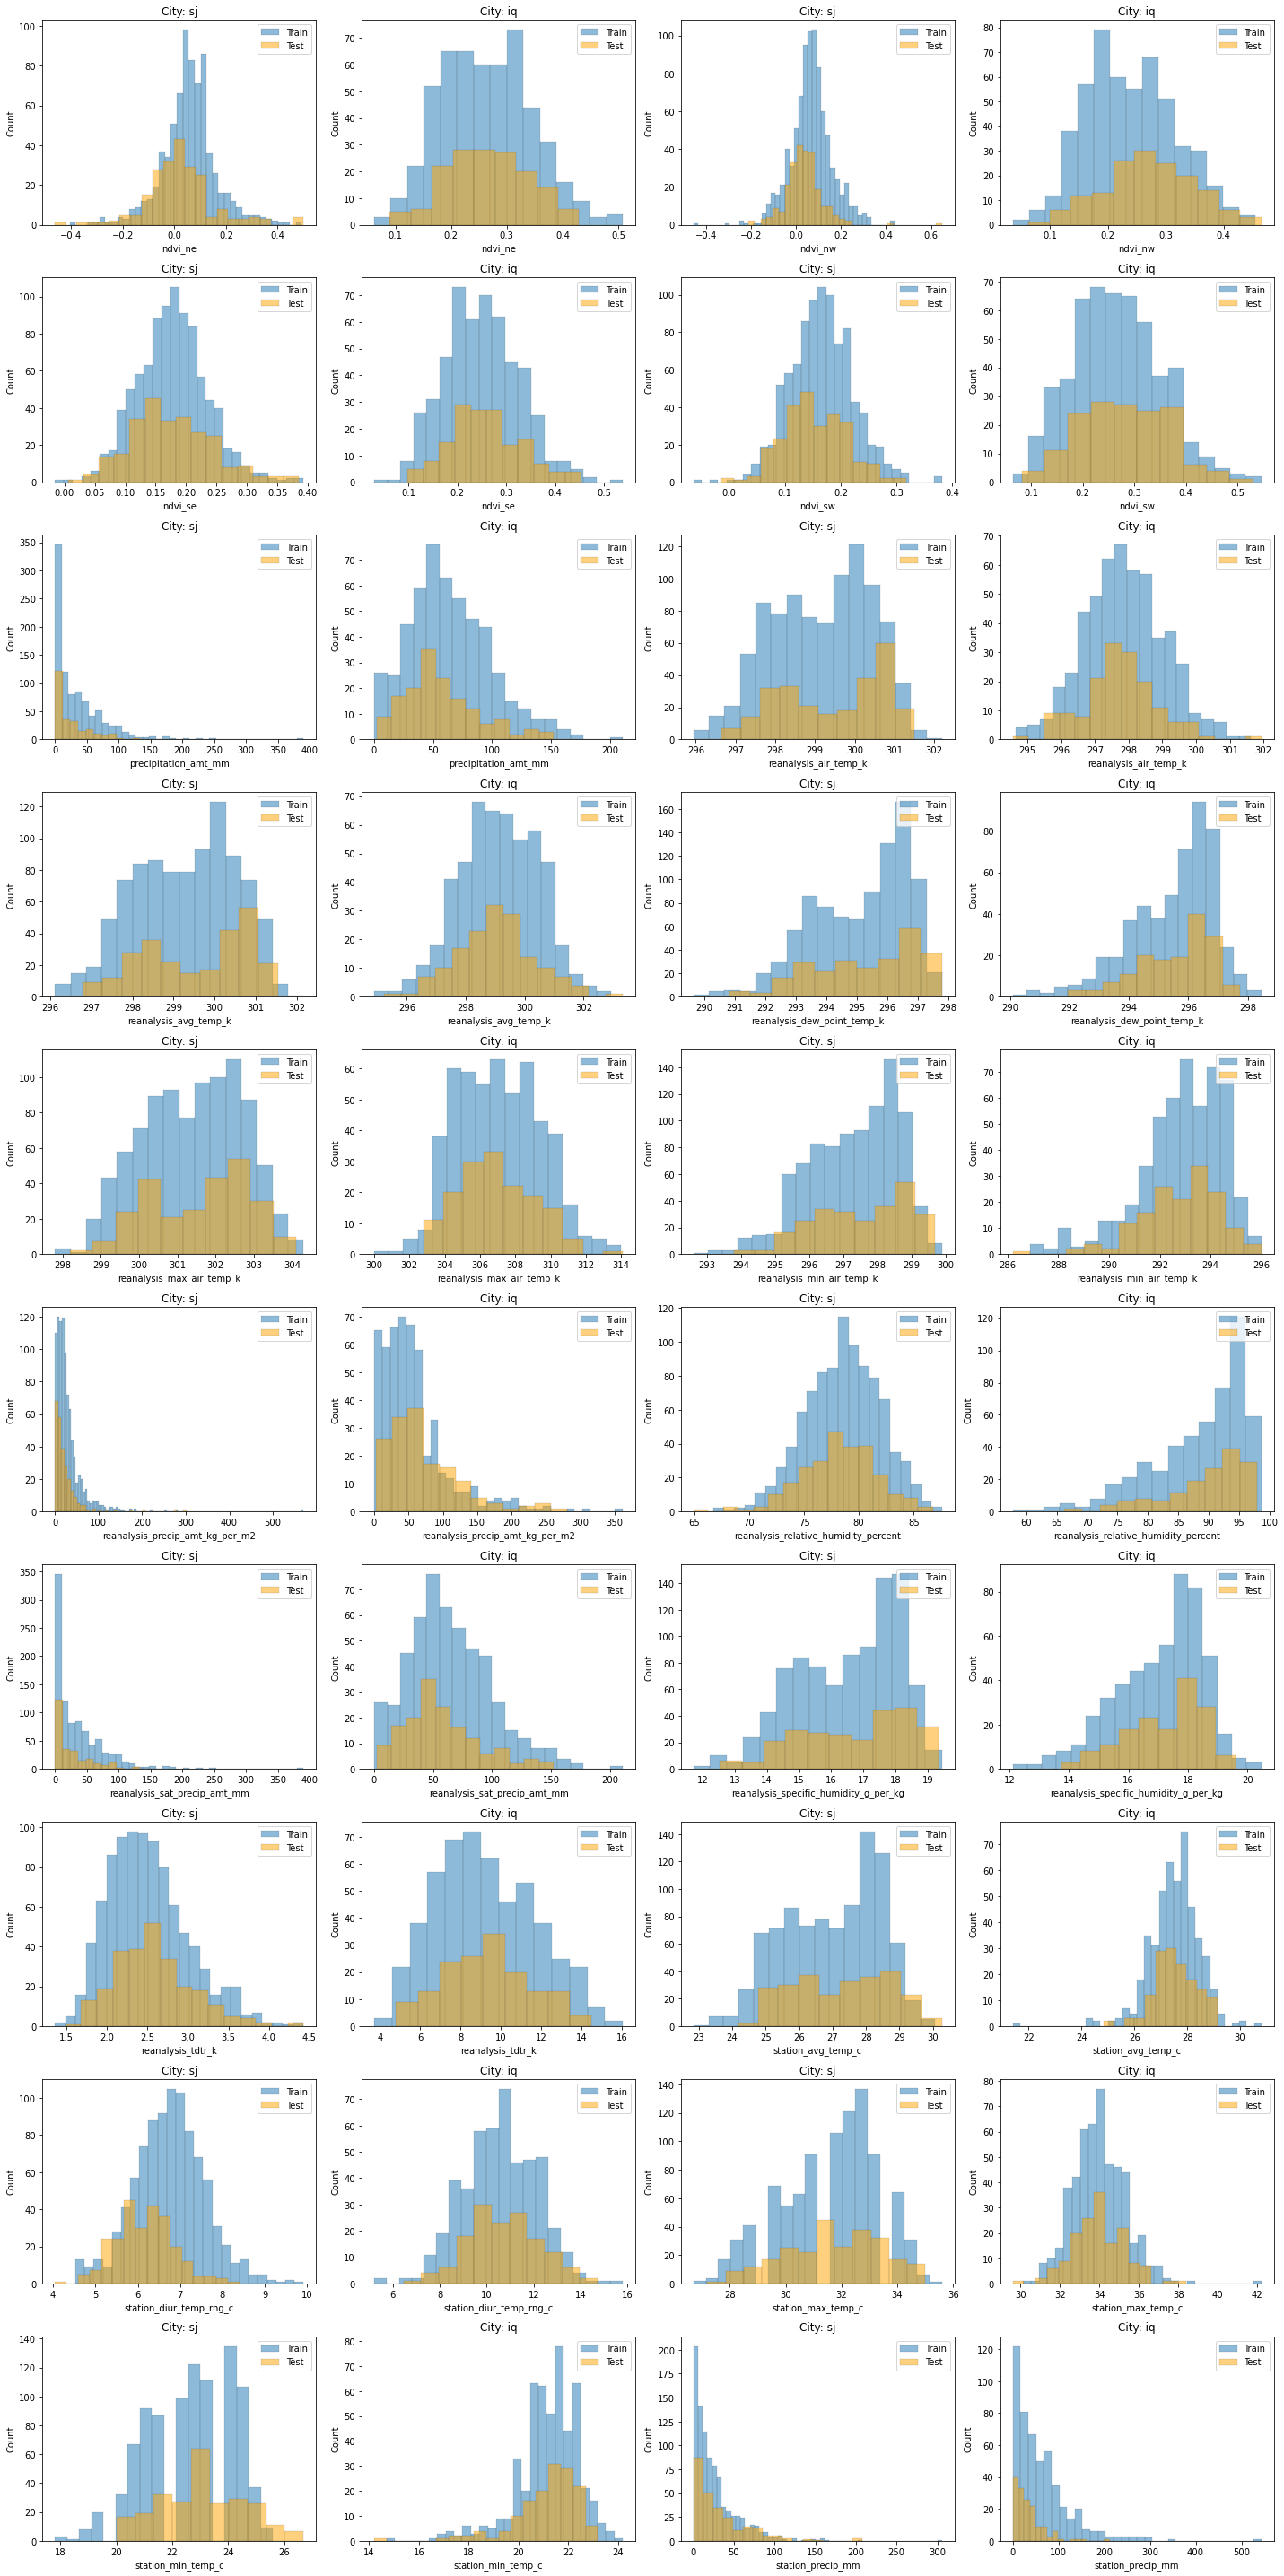

In [101]:
cities = ["sj", "iq"]

num_city = len(cities)
num_cols = int(np.sqrt(len(numeric_cols)))
num_rows = int(np.ceil(len(numeric_cols) / num_cols) * num_city)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
for i, col_name in enumerate(numeric_cols):
    for j, city in enumerate(cities):
        col = int((i * num_city + j) % num_cols)
        row = int((i * num_city + j) / num_cols)
        sns.histplot(df_train_features[col_name][df_train_features["city"] == city].dropna(),
                     alpha=0.5, linewidth=0.1, label="Train", ax=ax[row][col])
        sns.histplot(df_test_features[col_name][df_test_features["city"] == city].dropna(),
                     color="orange", alpha=0.5, linewidth=0.1, label="Test", ax=ax[row][col])
        ax[row][col].legend(loc="upper right")
        ax[row][col].set_title(f"City: {city}")
fig.tight_layout()

There doesn't appear to be significant differences between the train and test dataset for each city. `nvdi_nw` in `iq` and `station_diur_temp_rng_c` in `sj` appears slightly different.

## Features over time by city

In [104]:
iq_start = df_train_features[df_train_features["city"] == "iq"]["week_start_date"].min()
iq_end = df_train_features[df_train_features["city"] == "iq"]["week_start_date"].max()
sj_start = df_train_features[df_train_features["city"] == "sj"]["week_start_date"].min()
sj_end = df_train_features[df_train_features["city"] == "sj"]["week_start_date"].max()

print(f"iq train date range: {iq_start} to {iq_end}")
print(f"sj train date range: {sj_start} to {sj_end}")

iq train date range: 2000-07-01 to 2010-06-25
sj train date range: 1990-04-30 to 2008-04-22


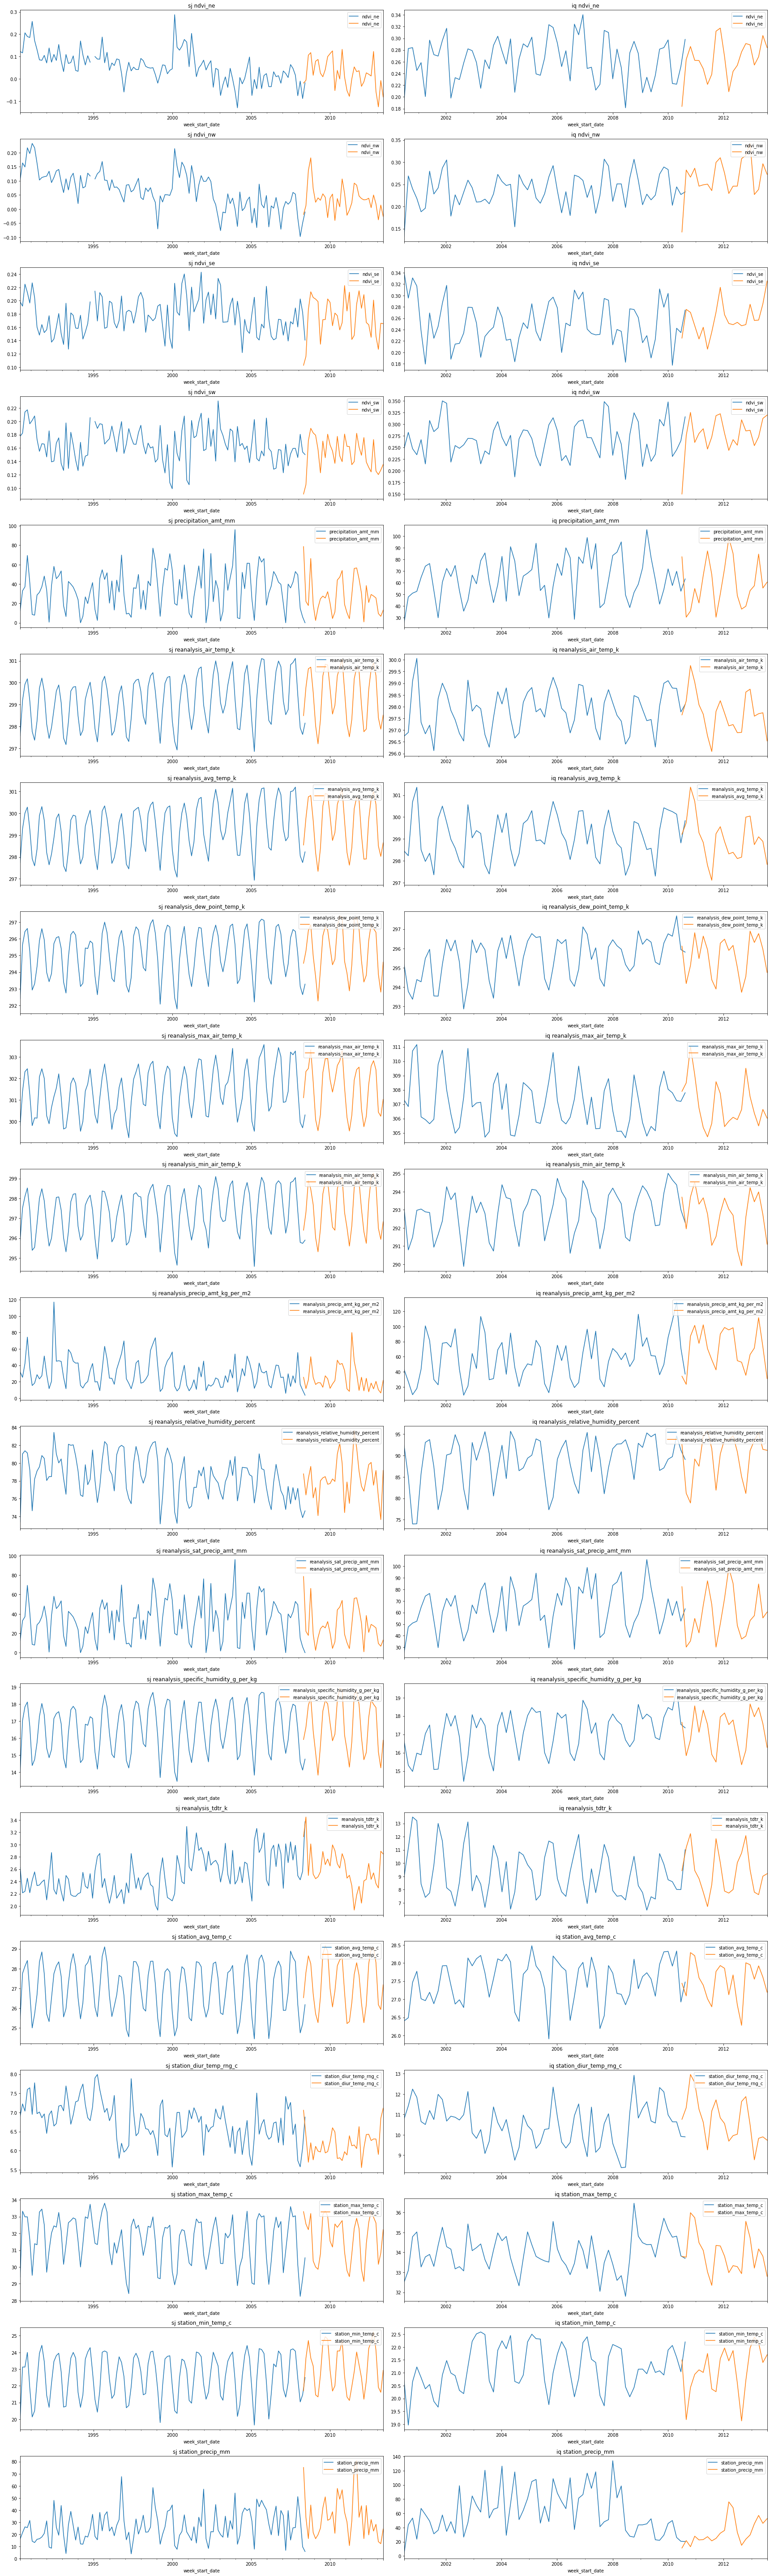

In [120]:
num_numeric_col = len(numeric_cols)
fig, ax = plt.subplots(num_numeric_col, num_city, figsize=(num_city * 12, num_numeric_col * 4))

for j, city in enumerate(cities):
    train_city_rows = df_train_features["city"] == city
    test_city_rows = df_test_features["city"] == city
    train_dates = pd.to_datetime(df_train_features[train_city_rows]["week_start_date"])
    test_dates = pd.to_datetime(df_test_features[test_city_rows]["week_start_date"])
    for i, col_name in enumerate(numeric_cols):
        df_train_features[train_city_rows][
            ["week_start_date", col_name]
        ].set_index(
            pd.DatetimeIndex(df_train_features[train_city_rows]["week_start_date"])
        ).groupby(pd.Grouper(freq="8W")).mean().plot(ax=ax[i][j])
        df_test_features[test_city_rows][
            ["week_start_date", col_name]
        ].set_index(
            pd.DatetimeIndex(df_test_features[test_city_rows]["week_start_date"])
        ).groupby(pd.Grouper(freq="8W")).mean().plot(ax=ax[i][j])

        ax[i][j].set_title(f"{city} {col_name}")
        ax[i][j].legend(loc="upper right")
fig.tight_layout()

Some features show clear cyclical trend, while some show an increase/decreasing trend over the years.

<AxesSubplot:>

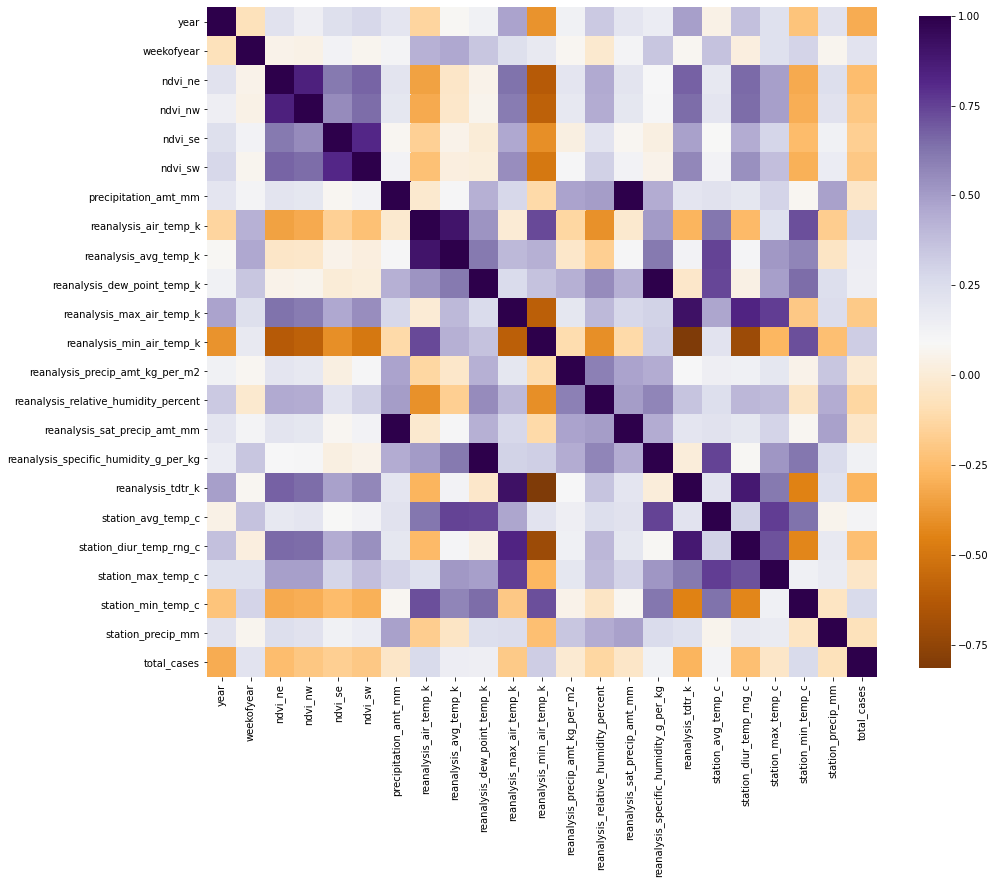

In [128]:
corr = df_train.corr()

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data=corr, cmap="PuOr", square=True, cbar_kws={"shrink": 0.8}, ax=ax)